## Bayesian model reduction for deep learning

Let us start with the following full generative model with normal priors over network parameters

\begin{equation}
    \begin{split}
        b_{li} &\sim \mathcal{N}\left(0, 1 \right) \\
        \omega_{lij} &\sim \mathcal{N}\left(0, 1 \right) \\
        y_n &\sim p\left(y| \pmb{W}, \pmb{X}_n  \right)
    \end{split}
\end{equation}

We look for the posterior in the form 
\begin{equation}
    \begin{split}
        p\left( \pmb{b}, \pmb{W}|\pmb{\mathcal{D}}\right) & \approx \prod_l \prod_i q\left(\pmb{b}_{li} \right) \prod_j q\left( \omega_{lij} \right)  \\
        q\left(\pmb{b}_{li} \right) &= \mathcal{N}\left(\pmb{\mu}_{li}^b, [\sigma^b_{li}]^2 \right) \\
        q\left( \pmb{W}_{li} \right) &= \mathcal{N}_{kt} \left( \pmb{\mu}_{lij}^\omega, \pmb{\pi}^{-1}_{lij}  \right)
    \end{split}
\end{equation}

The extended model introduces the following hierarchical prior over network weights

\begin{equation}
    \begin{split}
        c_l^2 &\sim \Gamma\left(2, 2 \right) \\
        \tau_{li} &\sim \mathcal{C}^{+}(0, 1) \\
        \lambda_{lij} &\sim \mathcal{C}^{+}(0, 1) \\
        \gamma^2_{lij} & = \frac{c_l^2 \tau^2_{li}\lambda^2_{lij}}{c_l^2 + \tau^2_{li}\lambda^2_{lij} } \\
        \omega_{lij} &\sim \mathcal{N}\left(0, \gamma^2_{lij} \right)
    \end{split}
\end{equation}

The change in the variational free energy is obtained as 

\begin{equation}
    \begin{split}
        \tilde{\pi}_{lij} &= \pi_{lij} + \gamma^{-2}_{lij} - \pi_0 \\
        \tilde{\mu}_{lij} &= \tilde{\pi}_{lij}^{-1} \pi_{lij} \mu_{lij} \\
        \Delta F\left( G \right) &= \ln E_{q(\pmb{W})}\left[ \frac{\tilde{p}(\pmb{W}| \pmb{G})}{p(\pmb{W})}\right] \\

        &= \frac{1}{2}\sum_{lij} \left[ \ln \left(\gamma^{-2}_{lij} \pi_{lij} \tilde{\pi}^{-1}_{lij}\right)  - \mu_{lij}^2 \pi_{lij} + \tilde{\mu}^2_{lij}\tilde{\pi}_{lij} \right]\\
        &= \frac{1}{2}\sum_{lij} \left[ - \ln\left( \gamma_{lij}^2 + \sigma^2_{lij} - \pi_0 \gamma_{lij}^2 \sigma^2_{lij}\right) - \mu_{lij}^2\pi_{lij}\left(1 - \tilde{\pi}_{lij}^{-1} \pi_{lij} \right) \right] \\
    \end{split}
\end{equation}


where $ \pmb{G}_{lij} = \pmb{\gamma}^2_{lij}$.

In [1]:
import os
# Set cuda device to use
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

# do not prealocate memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ["XLA_PYTHON_CLIENT_ALLOCATOR"] = "platform"

from numpyro import set_platform

set_platform('gpu') # cpu, gpu

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import numpy as np
import jax.numpy as jnp
from jax import random, vmap, nn, lax, devices, device_put
from jax.nn import one_hot
import matplotlib.pyplot as plt
import seaborn as sns

print(devices('gpu'), devices('cpu'))
rng_key = random.PRNGKey(0)
sns.set_theme(context='notebook', style='white', font_scale=1.6, color_codes=True)

[StreamExecutorGpuDevice(id=0, process_index=0, slice_index=0)] [CpuDevice(id=0)]


In [4]:
from numpyro import sample, param, handlers, prng_key
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, SVI, Trace_ELBO, TraceMeanField_ELBO, Predictive
from numpyro.infer.autoguide import AutoNormal, AutoDelta
from numpyro.optim import optax_to_numpyro
import optax

import equinox as eqx
from numpyro import module, param, handlers, plate, subsample, sample, deterministic
import numpyro.distributions as dist

from functools import partial

from models import BayesRegression, SVIRegression, BMRRegression
from networks import MLP

2023-02-27 14:07:57.595543: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-02-27 14:07:58.211740: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-02-27 14:07:58.265121: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


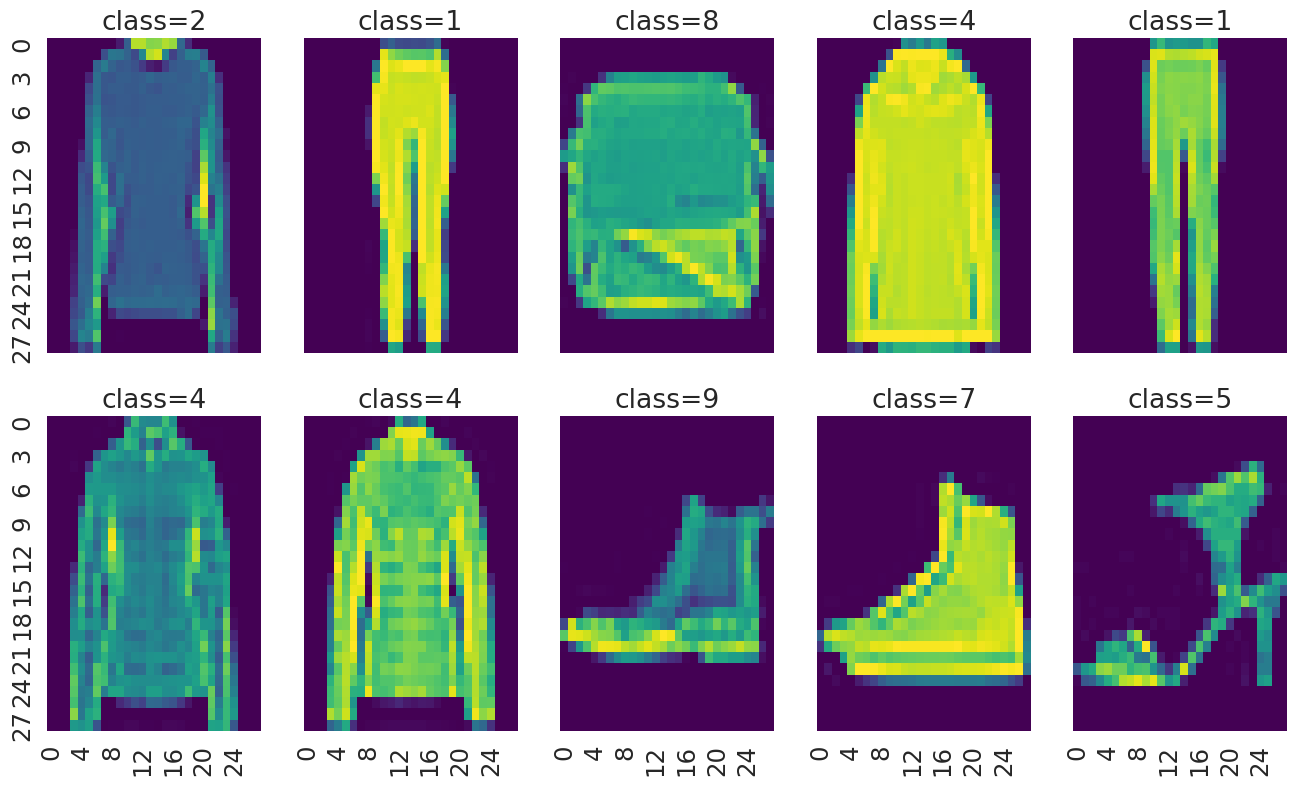

In [5]:
from numpc.datasets import load_data

# load data
train_ds, test_ds = load_data('fashion_mnist')
fig, axes = plt.subplots(2, 5, figsize=(16, 9), sharex=True, sharey=True)

for n in range(5):
    sns.heatmap(train_ds['image'][n].squeeze(), cmap='viridis', ax = axes[0, n], cbar=False, vmax=1., vmin=0.)
    axes[0, n].set_title('class={}'.format(train_ds['label'][n]))
    sns.heatmap(test_ds['image'][n].squeeze(), cmap='viridis', ax = axes[1, n], cbar=False, vmax=1., vmin=0.)
    axes[1, n].set_title('class={}'.format(test_ds['label'][n]))


train_ds['image'] = train_ds['image'].squeeze().reshape(train_ds['image'].shape[0], -1)
test_ds['image'] = test_ds['image'].squeeze().reshape(test_ds['image'].shape[0], -1)

_, in_size = train_ds['image'].shape
out_size = len(jnp.unique(train_ds['label']))

# number of neurons in hidden layer
num_hn = [40, 60, 80, 100, 200, 300, 400]

2023-02-27 14:08:00.212770: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


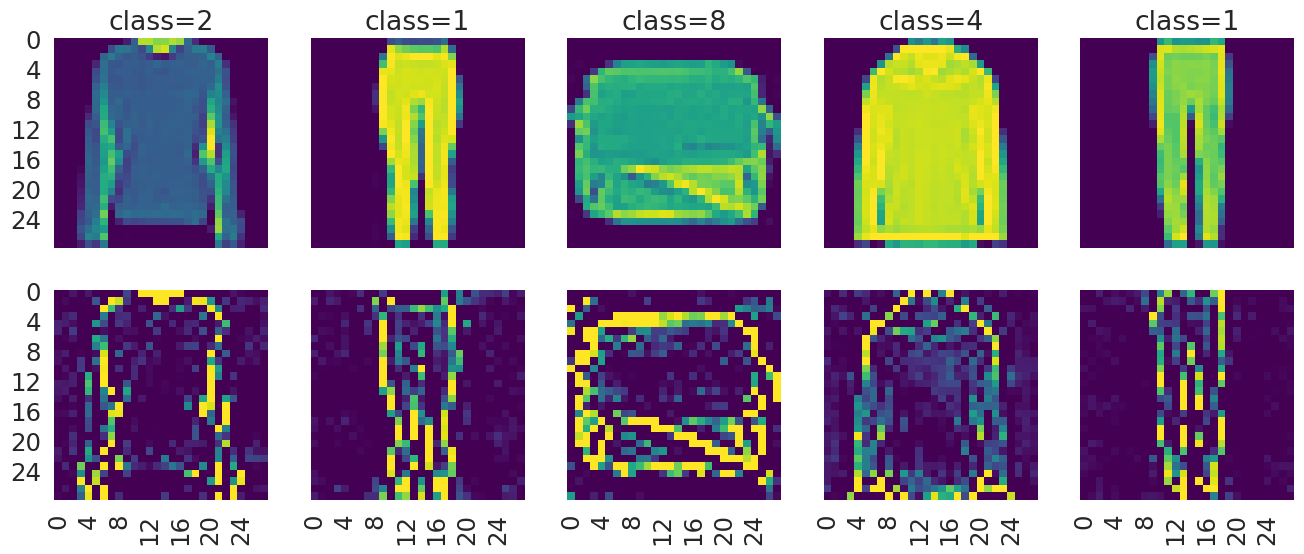

In [6]:
# whitening
mean = train_ds['image'].mean(0)

cov_matrix = jnp.cov(train_ds['image'].T)
eigen_values, eigen_vectors = jnp.linalg.eigh(cov_matrix)
variance_explained = 100 * eigen_values/jnp.sum(eigen_values)
keep = variance_explained.cumsum() > 0
W_pca = eigen_vectors[:, keep] / jnp.sqrt(eigen_values[keep])
W_zca = W_pca @ eigen_vectors[:, keep].T

X = (train_ds['image'] - mean) @ W_zca
X_test = (test_ds['image'] - mean) @ W_zca
in_size = X.shape[1]

fig, axes = plt.subplots(2, 5, figsize=(16, 6), sharex=True, sharey=True)

for n in range(5):
    sns.heatmap(train_ds['image'][n].reshape(28, 28), cmap='viridis', ax = axes[0, n], cbar=False, vmax=1., vmin=0.)
    axes[0, n].set_title('class={}'.format(train_ds['label'][n]))
    sns.heatmap(X[n].reshape(28, 28), cmap='viridis', ax = axes[1, n], cbar=False, vmax=1., vmin=0.)


In [7]:
import tensorflow_probability.substrates.jax.stats as stats
import tensorflow as tf
from numpyro.infer import log_likelihood

def mean_ll(log_like):

    S = log_like.shape[0]
    ll = nn.logsumexp(log_like - jnp.log(S), axis=0) 
    lpd = nn.logsumexp(log_like.sum(-1) - jnp.log(S))

    return ll, lpd 

def test_smpl(rng_key, model, sample, labels):
    pred = Predictive(model, posterior_samples=sample, parallel=True, return_sites=['obs', 'probs'])

    ll = log_likelihood(model, sample, parallel=True, obs=labels)


    ll, lpd = mean_ll(ll['obs'])

    rng_key, _rng_key = random.split(rng_key)
    pred_sample = pred(_rng_key)

    probs = pred_sample['probs'].mean(0)
    pred_labels = probs.argmax(-1)
    logits = jnp.log(probs)

    hit = pred_labels == labels
    acc = hit.mean(-1)

    ece = stats.expected_calibration_error_quantiles(
            hit, tf.math.log(probs.max(-1)), num_buckets=9
        )

    return {
        'ece': ece[0],
        'acc': acc,
        'nll': -ll.mean(),
        'lpd': lpd.item()
    }

In [8]:
try:
    res = jnp.load('comp_images.npz', allow_pickle=True)['results'].item()
except:   
    res = {
        'MAP': [],
        'NUTS': [],
        'SVI': [],
        'No-BMR': [],
        'BMR': [],
    }

In [ ]:
depth = 1
res['MAP'] = []
opts = {
    'num_steps': 500_000,
    'batch_size': 512,
    'num_samples': 1
}

for nh in num_hn:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    svi_reg = SVIRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial',
        with_hyperprior=False
    )
    
    smpl = svi_reg.fit(
        train_ds['label'], 
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        num_particles=1,
        progress_bar=True
    )

    smpl.pop('obs')
    svi_reg.set_input(X_test)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, svi_reg.model, lax.stop_gradient(smpl), test_ds['label'])
    out['DF'] = svi_reg.results.losses[-10000:-5000].mean() - svi_reg.results.losses[-5000:].mean()
    res['MAP'].append( (depth, nh, out, opts, smpl) )
    print(out['DF'], out['lpd'], out['acc'], out['ece'])

    del svi_reg

jnp.savez('comp_images.npz', results=res)

In [ ]:
method = 'SVI'
depth = 1
res[method] = []
opts = {
    'num_steps': 500_000,
    'batch_size': 512,
    'num_samples': 100
}

for nh in num_hn:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    svi_reg = SVIRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial'
    )
    
    smpl = svi_reg.fit(
        train_ds['label'], 
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        progress_bar=False,
        autoguide='mean-field'
    )

    smpl.pop('obs')
    svi_reg.set_input(X_test)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, svi_reg.model, lax.stop_gradient(smpl), test_ds['label'])
    out['DF'] = svi_reg.results.losses[-10000:-5000].mean() - svi_reg.results.losses[-5000:].mean()
    res[method].append( (depth, nh, out, opts, smpl) )
    print(out['DF'], out['lpd'], out['acc'], out['ece'])

    del svi_reg

jnp.savez('comp_images.npz', results=res)

1 40
21.44336 -3732.3447265625 0.8775 0.0035471362
1 60
11.630859 -3623.37451171875 0.8846 0.00789587
1 80
10.228516 -3714.431640625 0.8807 0.0032586996
1 100
-8.847656 -3814.53515625 0.87839997 0.005198297
1 200
15.277344 -3643.682373046875 0.87979996 0.0072993953
1 300
9.6796875 -3703.22119140625 0.87839997 0.0065584695
1 400
19.097656 -3752.846923828125 0.8743 0.005530622


In [ ]:
depth = 1
opts = {
    'num_steps': 400_000,
    'batch_size': 512,
    'num_samples': 100,
    'sigma0': 1.
}

for method in ['No-BMR', 'BMR']:
    res[method] = []

for nh in num_hn:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    bmr_reg = BMRRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial',
        sigma0=opts['sigma0']
    )
    
    bmr_reg.fit(
        train_ds['label'],
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        progress_bar=False
    )
    
    bmr_reg.samples.pop('obs')
    smpl1 = bmr_reg.samples
    
    bmr_reg.set_input(X_test)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, bmr_reg.model, smpl1, test_ds['label'])
    out['DF'] = bmr_reg.results.losses[-10000:-5000].mean() - bmr_reg.results.losses[-5000:].mean()
    res['No-BMR'].append( (depth, nh, out, opts, lax.stop_gradient(smpl1)) )
    print('No-BMR:', out['DF'], out['lpd'], out['acc'], out['ece'])


    results, smpl = bmr_reg.bmr(
        'mean-field', 
        num_samples=opts['num_samples'],
        num_steps=50_000,
        progress_bar=False
    )
    smpl.pop('obs')

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, bmr_reg.model, smpl, test_ds['label'])
    out['DF'] = results.losses[-10000:-5000].mean() - results.losses[-5000:].mean()
    res['BMR'].append( (depth, nh, out, opts, lax.stop_gradient(smpl)) )
    print('BMR:', out['DF'], out['lpd'], out['acc'], out['ece'])

    del bmr_reg

jnp.savez('comp_images.npz', results=res)

1 40
No-BMR: -5.7402344 -3691.842041015625 0.8904 0.005344832
BMR: -0.083496094 -3605.613037109375 0.88769996 0.006588972
1 60
No-BMR: -5.6777344 -3742.42236328125 0.8904 0.0052804
BMR: -1.1833496 -3624.440185546875 0.8876 0.008185206
1 80
No-BMR: 10.185547 -3711.282470703125 0.8919 0.008830932
BMR: -0.5698242 -3599.446533203125 0.891 0.004778056
1 100
No-BMR: -2.9121094 -3777.52099609375 0.8935 0.006628679
BMR: -1.9111328 -3631.496337890625 0.8922 0.0050546736
1 200
No-BMR: -4.21875 -4104.0869140625 0.891 0.0067178304
BMR: -1.3613281 -3906.787841796875 0.8882 0.012373948
1 300
No-BMR: 2.4296875 -4766.96484375 0.8939 0.0047298754
BMR: -0.31054688 -4723.77783203125 0.8886 0.016979117
1 400
No-BMR: 8.8046875 -7799.228515625 0.8893 0.016009487
BMR: -0.2578125 -7351.60400390625 0.8832 0.029797347


In [9]:
method = 'NUTS'
depth = 1
res[method] = []
opts = {
    'num_samples': 100,
    'warmup_steps': 1000
}

for nh in num_hn:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    bayes_reg = BayesRegression(
        _rng_key, 
        X, 
        dense_net,
        regtype='multinomial'
    )
    
    smpl = bayes_reg.fit(
        train_ds['label'], 
        num_samples=opts['num_samples'], 
        warmup_steps=opts['warmup_steps'],
        progress_bar=True
    )

    bayes_reg.set_input(X_test)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, bayes_reg.model, lax.stop_gradient(smpl), test_ds['label'])
    res[method].append( (depth, nh, out, opts, smpl) )topq
    print(out['lpd'], out['acc'], out['ece'])

    del bayes_reg

jnp.savez('comp_images.npz', results=res)

1 40


sample: 100%|██████████| 1100/1100 [5:55:00<00:00, 19.36s/it, 1023 steps of size 1.72e-03. acc. prob=0.88] 


-4406.68359375 0.8964 0.005515648
1 60


warmup:   2%|▏         | 24/1100 [06:39<7:00:23, 23.44s/it, 1023 steps of size 5.07e-06. acc. prob=0.59]

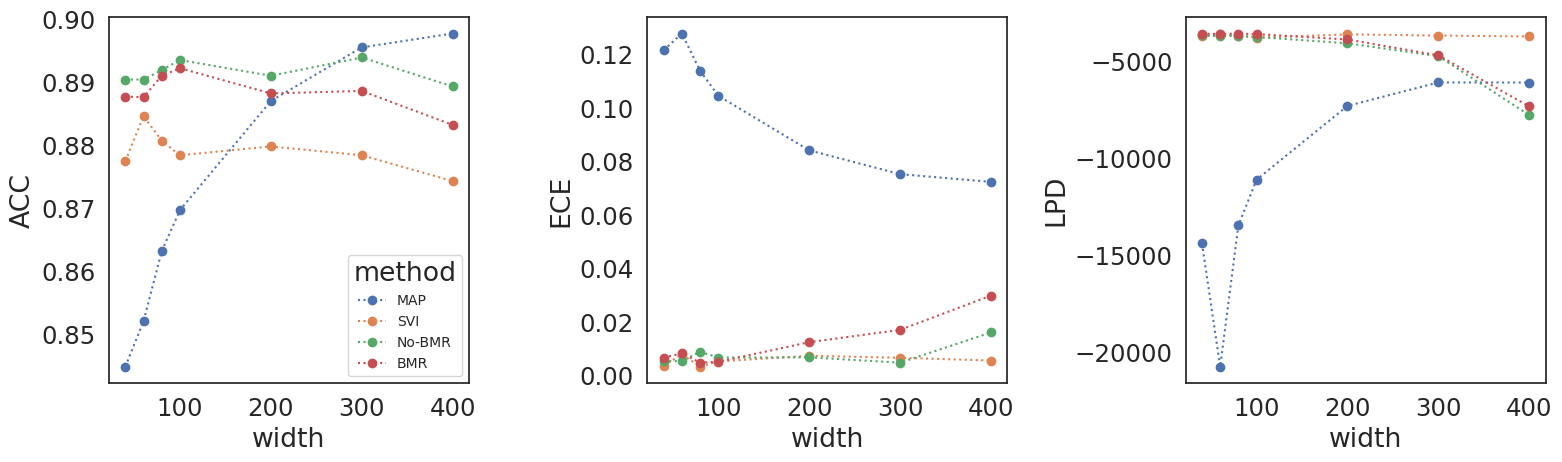

In [ ]:
import pandas as pd
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=False)

for key in ['MAP', 'SVI', 'No-BMR', 'BMR']:

    for i, metric in enumerate(['acc', 'ece', 'lpd']):
        axes[i].plot([tpl[1] for tpl in res[key]], [tpl[2][metric] for tpl in res[key]], 'o:', label=key)
        axes[i].set_xlabel('width')
        axes[i].set_ylabel(metric.upper())

axes[0].legend(title='method', fontsize=10)
fig.tight_layout()

In [8]:
from optax_adan import adan
from optax import adabelief
opt1 = adan
opt2 = lambda *args, **kwargs: adabelief(*args, eps=1e-16, eps_root=1e-16, **kwargs)

def optimizer(learning_rate, steps):
    return optax.chain(
        optax.clip_by_global_norm(1e1),
        adabelief(learning_rate)
    )

3 100


2023-02-23 13:29:45.947054: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-02-23 13:29:46.937857: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


3 100
3 100


2023-02-23 13:32:49.055776: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


3 100
3 100
3 100
3 100
3 100
3 100
3 100
3 100
3 100
3 100
3 100
3 100
3 100


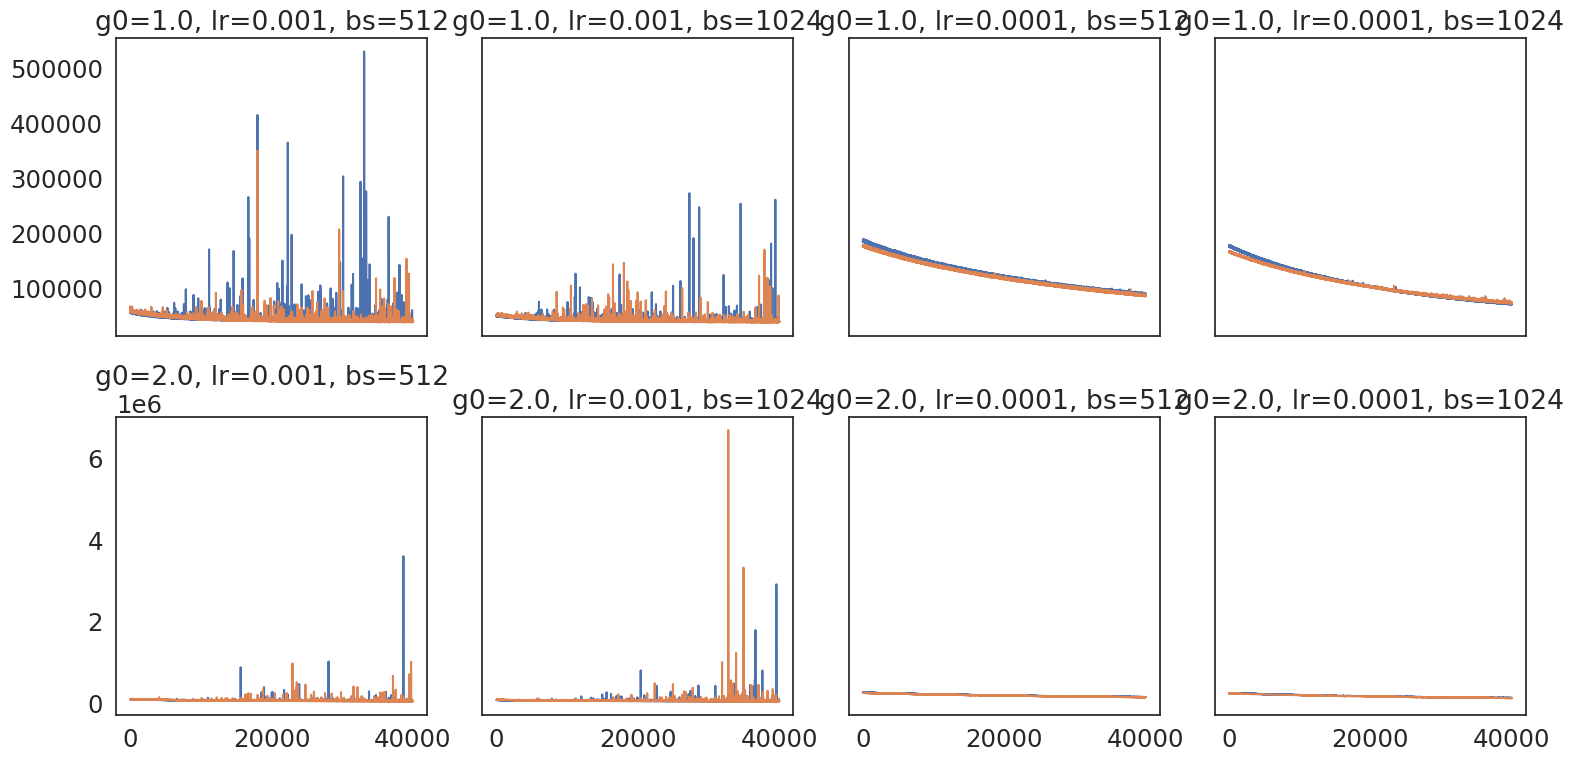

In [9]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), sharex=True, sharey='row')
axes = axes.flatten()
depth = 3
nh = 100

opts = {
    'num_steps': 50_000,
    'num_samples': 1
}

i = 0
for g0 in [1., 2.]:
    for lr in [1e-3, 1e-4]:
        for bs in [512, 1024]:
            losses = []
            for optim in [opt2, lambda learning_rate: optimizer(learning_rate, opts['num_steps'])]:
                print(depth, nh)
                rng_key, _rng_key = random.split(rng_key)
                dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

                rng_key, _rng_key = random.split(rng_key)
                map_reg = BMRRegression(
                    _rng_key, 
                    X, 
                    dense_net,
                    batch_size=bs, 
                    regtype='multinomial',
                    gamma0=g0,
                    posterior='normal',
                    optimizer=optim
                )
                
                map_reg.fit(
                    train_ds['label'],
                    num_samples=opts['num_samples'], 
                    num_steps=opts['num_steps'],
                    progress_bar=False,
                    opt_kwargs={'learning_rate': lr}
                )

                losses.append(map_reg.results.losses)

                del map_reg
            
            for loss in losses:
                axes[i].plot(loss[-40000:])
            axes[i].set_title(f'g0={g0}, lr={lr}, bs={bs}')
            i += 1

fig.tight_layout()

In [17]:
try:
    res = jnp.load('comp_images_depth.npz', allow_pickle=True)['results'].item()
except:   
    res = {
        'MAP': [],
        'NUTS': [],
        'SVI': [],
        'No-BMR': [],
        'BMR': [],
    }

In [ ]:
def optimizer(learning_rate, steps):
    return optax.chain(
        optax.clip_by_global_norm(1e2),
        optax.adabelief(learning_rate)
    )

method = 'MAP'
res[method] = []
opts = {
    'num_steps': 200_000,
    'batch_size': 1024,
    'num_samples': 1,
    'lr': 1e-4,
    'gamma0': 1.
}

optim = lambda learning_rate: optimizer(learning_rate, 100)

losses = []
nh = 100
for depth in [1, 2, 3, 4, 5]:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    map_reg = BMRRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial',
        gamma0=opts['gamma0'],
        posterior='delta',
        optimizer=optim
    )
    
    map_reg.fit(
        train_ds['label'],
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        progress_bar=False,
        opt_kwargs={'learning_rate': opts['lr']}
    )

    losses.append(map_reg.results.losses)
    
    map_reg.samples.pop('obs')    
    map_reg.set_input(X_test)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, map_reg.model, map_reg.samples, test_ds['label'])
    out['DF'] = map_reg.results.losses[-10000:-5000].mean() - map_reg.results.losses[-5000:].mean()
    res[method].append( (depth, nh, out, opts, map_reg.samples) )
    print(out['DF'], out['lpd'], out['acc'], out['ece'])

jnp.savez('comp_images_depth.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot(loss[-10_000:])

1 100


2023-02-27 13:01:52.799203: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-02-27 13:01:54.170809: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-02-27 13:02:03.151517: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-02-27 13:02:03.184137: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


14.578125 -4885.2880859375 0.8577 0.0079853805
2 100
11.972656 -4631.5185546875 0.8598 0.0065357075
3 100
15.964844 -4588.0458984375 0.8621 0.005788313
4 100
9.5859375 -4758.361328125 0.8567 0.00825076
5 100
14.7109375 -4705.35888671875 0.8595 0.0062077497


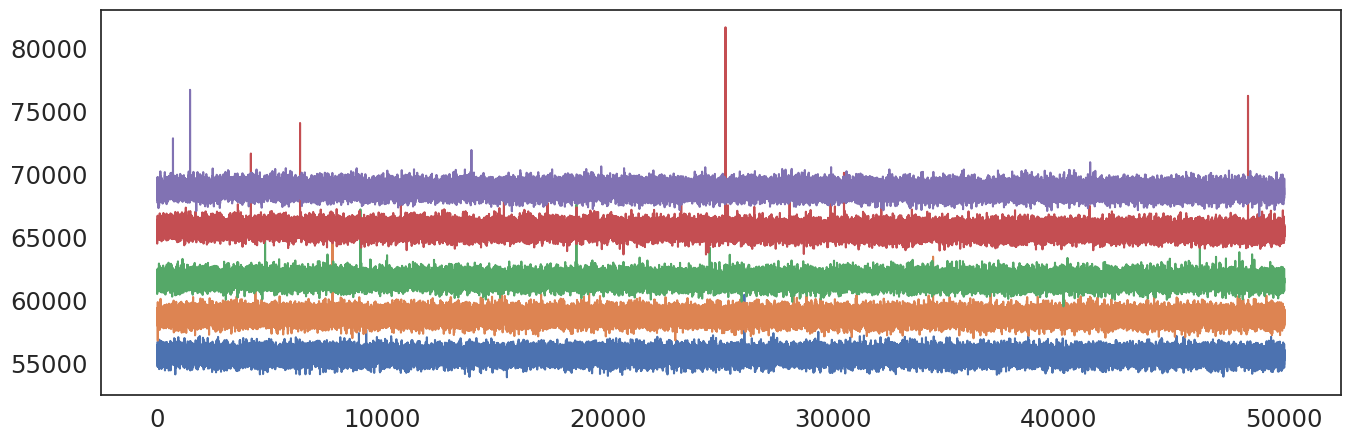

In [9]:
method = 'SVI'
res[method] = []
opts = {
    'num_steps': 200_000,
    'batch_size': 1024,
    'num_samples': 100,
    'num_particles': 10,
    'lr': 1e-3
}

nh = 100
losses = []
for depth in [1, 2, 3, 4, 5]:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    svi_reg = SVIRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial'
    )
    
    smpl = svi_reg.fit(
        train_ds['label'], 
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        num_particles=opts['num_particles'],
        autoguide='mean-field',
        opt_kwargs={'learning_rate': opts['lr']}
    )

    losses.append(svi_reg.results.losses)

    smpl.pop('obs')
    svi_reg.set_input(X_test)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, svi_reg.model, lax.stop_gradient(smpl), test_ds['label'])
    out['DF'] = svi_reg.results.losses[-10000:-5000].mean() - svi_reg.results.losses[-5000:].mean()
    res[method].append( (depth, nh, out, opts, smpl) )
    print(out['DF'], out['lpd'], out['acc'], out['ece'])

    del svi_reg

jnp.savez('comp_images_depth.npz', results=res)
plt.figure(figsize=(16, 5))
for loss in losses:
    plt.plot(loss[-50_000:])

1 100


2023-02-27 14:14:00.231597: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none
2023-02-27 14:14:01.203106: E external/org_tensorflow/tensorflow/compiler/xla/python/pjit.cc:606] fastpath_data is none


No-BMR: 25.59375 -5389.39697265625 0.8592 0.007943293
BMR: -0.1640625 -5956.330078125 0.8373 0.02075593
2 100
No-BMR: -27.039062 -4796.44140625 0.85969996 0.010292695
BMR: -0.087890625 -7267.23046875 0.83629996 0.01038869
3 100
No-BMR: -8121.949 -4860.19384765625 0.8609 0.010298974
BMR: 3.6484375 -5288.32666015625 0.8481 0.008065649
4 100
No-BMR: -56612.188 -5093.92138671875 0.8477 0.0092456555
BMR: 0.69140625 -7433.634765625 0.7601 0.019400315
5 100
No-BMR: -152153.69 -5042.99560546875 0.85639995 0.0057423697
BMR: 1.5703125 -5868.12841796875 0.8283 0.019698903


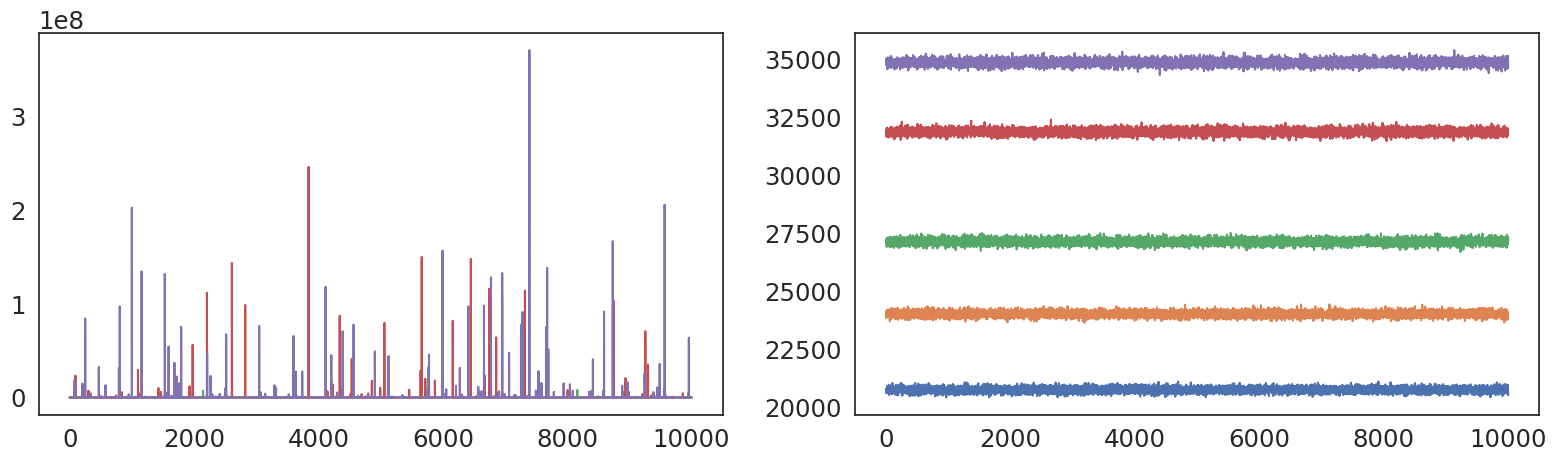

In [18]:
def optimizer(learning_rate):
    return optax.chain(
        optax.clip_by_global_norm(1e1),
        optax.adabelief(learning_rate)
    )

opts = {
    'num_steps': 200_000,
    'batch_size': 1024,
    'num_samples': 100,
    'num_particles': 10,
    'gamma0': 2.,
    'lr': 1e-3
}

for method in ['No-BMR', 'BMR']:
    res[method] = []

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
nh = 100
losses = []
for depth in [1, 2, 3, 4, 5]:
    print(depth, nh)
    rng_key, _rng_key = random.split(rng_key)
    dense_net = MLP(in_size, out_size=out_size, width_size=nh, depth=depth, key=_rng_key)

    rng_key, _rng_key = random.split(rng_key)
    bmr_reg = BMRRegression(
        _rng_key, 
        X, 
        dense_net,
        batch_size=opts['batch_size'], 
        regtype='multinomial',
        gamma0=opts['gamma0'],
        posterior='normal',
        optimizer=optimizer
    )
    
    bmr_reg.fit(
        train_ds['label'],
        num_samples=opts['num_samples'], 
        num_steps=opts['num_steps'],
        num_particles=opts['num_particles'],
        progress_bar=False,
        opt_kwargs={'learning_rate': opts['lr']}
    )

    losses.append(bmr_reg.results.losses)
    axes[0].plot(losses[-1][-10_000:])

    bmr_reg.samples.pop('obs')
    smpl1 = bmr_reg.samples
    
    bmr_reg.set_input(X_test)

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, bmr_reg.model, smpl1, test_ds['label'])
    out['DF'] = bmr_reg.results.losses[-10000:-5000].mean() - bmr_reg.results.losses[-5000:].mean()
    res['No-BMR'].append( (depth, nh, out, opts, lax.stop_gradient(smpl1)) )
    print('No-BMR:', out['DF'], out['lpd'], out['acc'], out['ece'])


    results, smpl = bmr_reg.bmr(
        'mean-field', 
        num_samples=opts['num_samples'],
        num_steps=40_000,
        num_particles=opts['num_particles'],
        progress_bar=False
    )
    smpl.pop('obs')
    axes[1].plot(results.losses[-10_000:])

    rng_key, _rng_key = random.split(rng_key)
    out = test_smpl(_rng_key, bmr_reg.model, smpl, test_ds['label'])
    out['DF'] = results.losses[-10000:-5000].mean() - results.losses[-5000:].mean()
    res['BMR'].append( (depth, nh, out, opts, lax.stop_gradient(smpl)) )
    print('BMR:', out['DF'], out['lpd'], out['acc'], out['ece'])

    del bmr_reg

jnp.savez('comp_images_depth.npz', results=res)

fig.tight_layout()

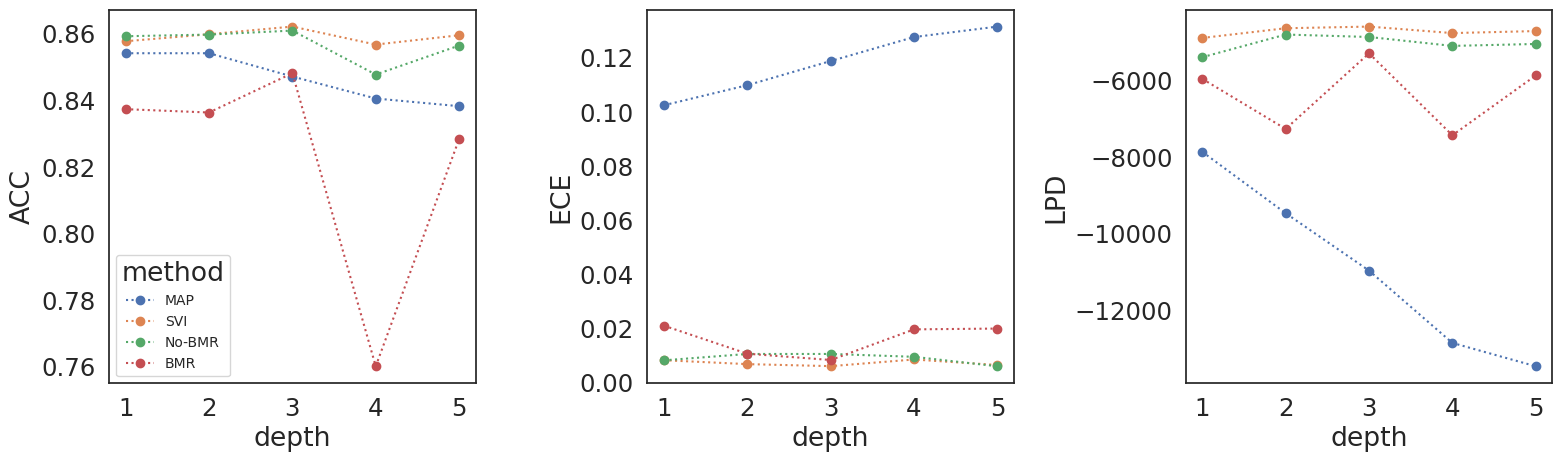

In [19]:
import pandas as pd
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharex=False)

for key in ['MAP', 'SVI', 'No-BMR', 'BMR']:

    for i, metric in enumerate(['acc', 'ece', 'lpd']):
        axes[i].plot([tpl[0] for tpl in res[key]], [tpl[2][metric] for tpl in res[key]], 'o:', label=key)
        axes[i].set_xlabel('depth')
        axes[i].set_ylabel(metric.upper())

axes[0].legend(title='method', fontsize=10)
fig.tight_layout()